In [1]:
import geopandas as gpd

In [2]:
import geopandas as gpd

print("123")

123


In [1]:
import geopandas as gpd

# 将 "file_path" 替换为你的 shp 文件的路径
file_path = "C:/Users/86900/output.shp"
data = gpd.read_file(file_path)

# 查看数据
print(data.head())

   release           capture_da  \
0        2  3/26/2020-7/22/2020   
1        2  3/26/2020-7/22/2020   
2        1                 None   
3        2  3/26/2020-7/22/2020   
4        2  3/26/2020-7/22/2020   

                                            geometry  
0  POLYGON ((-84.95963 32.42189, -84.95964 32.421...  
1  POLYGON ((-84.95964 32.42095, -84.95964 32.420...  
2  POLYGON ((-84.96000 32.23523, -84.96000 32.235...  
3  POLYGON ((-84.96025 32.42225, -84.96025 32.422...  
4  POLYGON ((-84.96160 32.41921, -84.96180 32.419...  


In [2]:
print(data.head())

   release           capture_da  \
0        2  3/26/2020-7/22/2020   
1        2  3/26/2020-7/22/2020   
2        1                 None   
3        2  3/26/2020-7/22/2020   
4        2  3/26/2020-7/22/2020   

                                            geometry  
0  POLYGON ((-84.95963 32.42189, -84.95964 32.421...  
1  POLYGON ((-84.95964 32.42095, -84.95964 32.420...  
2  POLYGON ((-84.96000 32.23523, -84.96000 32.235...  
3  POLYGON ((-84.96025 32.42225, -84.96025 32.422...  
4  POLYGON ((-84.96160 32.41921, -84.96180 32.419...  


In [3]:
print(data.loc[0])

release                                                       2
capture_da                                  3/26/2020-7/22/2020
geometry      POLYGON ((-84.959634 32.421887, -84.959636 32....
Name: 0, dtype: object


In [4]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape

def main():
    # this is the name of the geography you want to retrieve. update to meet your needs
    location = 'UnitedStates'

    dataset_links = pd.read_csv("https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv")
    greece_links = dataset_links[dataset_links.Location == location]
    for _, row in greece_links.iterrows():
        df = pd.read_json(row.Url, lines=True)
        df['geometry'] = df['geometry'].apply(shape)
        gdf = gpd.GeoDataFrame(df, crs=4326)
        gdf.to_file(f"{row.QuadKey}.geojson", driver="GeoJSON")


if __name__ == "__main__":
    main()

In [12]:
import pandas as pd
import geopandas as gpd
import shapely.geometry
import mercantile
from tqdm import tqdm
import os
import tempfile
import fiona

aoi_geom = {
    "coordinates": [
        [
            [-74.257159, 40.495992],
            [-73.699793, 40.495992], 
            [-73.699793, 40.915568], 
            [-74.257159, 40.915568],
            [-74.257159, 40.495992]
        ]
    ],
    "type": "Polygon",
}
aoi_shape = shapely.geometry.shape(aoi_geom)
minx, miny, maxx, maxy = aoi_shape.bounds

output_fn = "NewYork.geojson"

quad_keys = set()
for tile in list(mercantile.tiles(minx, miny, maxx, maxy, zooms=9)):
    quad_keys.add(int(mercantile.quadkey(tile)))
quad_keys = list(quad_keys)
print(f"The input area spans {len(quad_keys)} tiles: {quad_keys}")

df = pd.read_csv(
    "https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv"
)

idx = 0
combined_rows = []

with tempfile.TemporaryDirectory() as tmpdir:
    # Download the GeoJSON files for each tile that intersects the input geometry
    tmp_fns = []
    for quad_key in tqdm(quad_keys):
        rows = df[df["QuadKey"] == quad_key]
        if rows.shape[0] == 1:
            url = rows.iloc[0]["Url"]

            df2 = pd.read_json(url, lines=True)
            df2["geometry"] = df2["geometry"].apply(shapely.geometry.shape)

            gdf = gpd.GeoDataFrame(df2, crs=4326)
            fn = os.path.join(tmpdir, f"{quad_key}.geojson")
            tmp_fns.append(fn)
            if not os.path.exists(fn):
                gdf.to_file(fn, driver="GeoJSON")
        elif rows.shape[0] > 1:
            raise ValueError(f"Multiple rows found for QuadKey: {quad_key}")
        else:
            raise ValueError(f"QuadKey not found in dataset: {quad_key}")

    # Merge the GeoJSON files into a single file
    for fn in tmp_fns:
        with fiona.open(fn, "r") as f:
            for row in tqdm(f):
                row = dict(row)
                shape = shapely.geometry.shape(row["geometry"])

                if aoi_shape.contains(shape):
                    if "id" in row:
                        del row["id"]
                    row["properties"] = {"id": idx}
                    idx += 1
                    combined_rows.append(row)

schema = {"geometry": "Polygon", "properties": {"id": "int"}}

with fiona.open(output_fn, "w", driver="GeoJSON", crs="EPSG:4326", schema=schema) as f:
    f.writerecords(combined_rows)

The input area spans 2 tiles: [32010110, 32010111]


  0%|          | 0/2 [00:00<?, ?it/s]


ValueError: Multiple rows found for QuadKey: 32010110

In [2]:
from shapely.geometry import Polygon

lon_min, lat_min, lon_max, lat_max = -86.237398, 32.5370610000001, -86.2056909999999, 32.5636660000001  # 适当替换为你的经纬度范围.
polygon = Polygon([(lon_min, lat_min), (lon_max, lat_min), (lon_max, lat_max), (lon_min, lat_max)])

# 用这个polygon筛选geo_dataframe
mask = data.within(polygon)
selected_data = data[mask]

NameError: name 'data' is not defined

In [10]:
print(selected_data.head())

       release          capture_da  \
25249        2  8/1/2018-10/1/2018   
25275        2  8/1/2018-10/1/2018   
25294        2  8/1/2018-10/1/2018   
25370        2  8/1/2018-10/1/2018   
25383        2  8/1/2018-10/1/2018   

                                                geometry  
25249  POLYGON ((-86.20713 32.54644, -86.20714 32.546...  
25275  POLYGON ((-86.20746 32.54346, -86.20758 32.543...  
25294  POLYGON ((-86.20806 32.54601, -86.20806 32.546...  
25370  POLYGON ((-86.20958 32.54281, -86.20975 32.542...  
25383  POLYGON ((-86.21008 32.54878, -86.21019 32.548...  


In [1]:
print(selected_data.loc[25249])

NameError: name 'selected_data' is not defined

In [18]:
from shapely.geometry import LineString, Polygon, MultiPoint, Point
import numpy as np

# 原点坐标
origin = Point(0, 0)
# 将角度转化为弧度
angles = [np.deg2rad(angle) for angle in [0, 45, 90, 135, 180, 225, 270, 315]]
# 500米对应的经纬度数值大致是0.0045
max_distance = 0.0045
# 假设存在一个多边形
polygon = Polygon([(0.001, 0.001), (0.001, 0.002), (0.002, 0.002), (0.002, 0.001)])


def find_reflected_ray(ray):
    # 找到交点
    intersection = ray.intersection(polygon.exterior)
    
    if intersection.is_empty:
        print("No intersection")
        return

    # 求出交点的坐标
    if isinstance(intersection, Point):
        hit_point = intersection.coords[0]
    elif isinstance(intersection, MultiPoint):
        hit_point = intersection.geoms[0].coords[0]  # 取第一个点作为交点

    # 找到多边形边的单位法线向量
    dx, dy = np.array(polygon.exterior.coords[0]) - np.array(hit_point)
    length = np.sqrt(dx ** 2 + dy ** 2)
    normal = np.array([dy / length, -dx / length])

    # 计算反射向量
    direction = np.array(ray.coords[-1]) - np.array(hit_point)
    direction /= np.linalg.norm(direction)

    reflection = direction - 2 * np.dot(direction, normal) * normal

    # 计算反射射线
    reflected_ray_end_point = hit_point + max_distance * reflection
    reflected_ray = LineString([hit_point, tuple(reflected_ray_end_point)])

    print(reflected_ray)


for angle in angles:
    # 创建射线
    dx, dy = np.cos(angle) * max_distance, np.sin(angle) * max_distance
    ray = LineString([origin, Point(origin.x + dx, origin.y + dy)])

    find_reflected_ray(ray)

No intersection
LINESTRING (0.002 0.002, 0.0051819805153395 0.0051819805153395)
No intersection
No intersection
No intersection
No intersection
No intersection
No intersection


In [21]:
def find_reflected_ray(ray, polygon):
    # 找到交点
    intersections = ray.intersection(polygon.exterior)

    if intersections.is_empty:
        return None  # 返回None表示没有反射

    # 求出交点的坐标
    if isinstance(intersections, Point):
        hit_point = intersections.coords[0]
    elif isinstance(intersections, MultiPoint):
        hit_point = intersections.geoms[0].coords[0]  # 取第一个点作为交点

    # 找到多边形边的单位法线向量
    dx, dy = np.array(polygon.exterior.coords[0]) - np.array(hit_point)
    length = np.sqrt(dx ** 2 + dy ** 2)
    normal = np.array([dy / length, -dx / length])

    # 计算反射向量
    direction = np.array(ray.coords[-1]) - np.array(hit_point)
    direction /= np.linalg.norm(direction)

    reflection = direction - 2 * np.dot(direction, normal) * normal

    # 计算反射射线
    reflected_ray_end_point = hit_point + max_distance * reflection
    reflected_ray = LineString([hit_point, tuple(reflected_ray_end_point)])

    return reflected_ray

polygons = [Polygon([(0.001, 0.001), (0.001, 0.002), (0.002, 0.002), (0.002, 0.001)]), 
            Polygon([(0.003, 0.001), (0.003, 0.004), (0.004, 0.002), (0.004, 0.001)]),
            ] 


for angle in angles:
    # 创建射线
    dx, dy = np.cos(angle) * max_distance, np.sin(angle) * max_distance
    ray = LineString([origin, Point(origin.x + dx, origin.y + dy)])

    for polygon in polygons:
        ray = find_reflected_ray(ray, polygon)
        print(ray)
        if ray is None:
            break  # 如果没有发生反射，就跳出循环

None
LINESTRING (0.002 0.002, 0.0051819805153395 0.0051819805153395)
LINESTRING (0.003 0.003, -0.0001819805153395 0.0061819805153395)
None
None
None
None
None
None


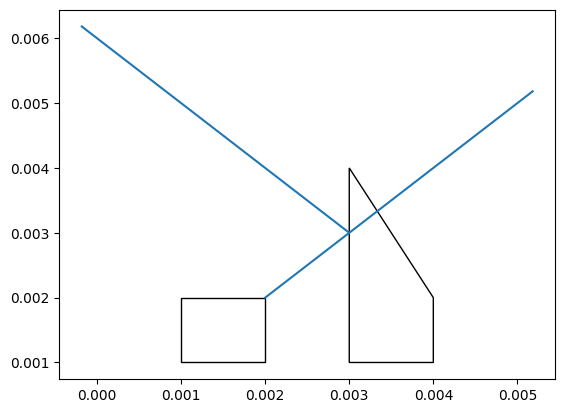

In [23]:
import matplotlib.pyplot as plt

# Create a blank figure with axes
fig = plt.figure()
ax = fig.add_subplot(111)

# Draw the polygons
for polygon in polygons:
    polygon = plt.Polygon(polygon.exterior.coords, fill=None)
    ax.add_patch(polygon)

# Calculate and draw the rays
for angle in angles:
    dx, dy = np.cos(angle) * max_distance, np.sin(angle) * max_distance
    ray = LineString([origin, Point(origin.x + dx, origin.y + dy)])

    for polygon in polygons:
        ray = find_reflected_ray(ray, polygon)
        if ray is None:
            break
        else:
            line = plt.Line2D(*ray.xy)
            ax.add_line(line)
            
# Make sure all shapes are included in the display
ax.relim()
ax.autoscale_view()

plt.show()

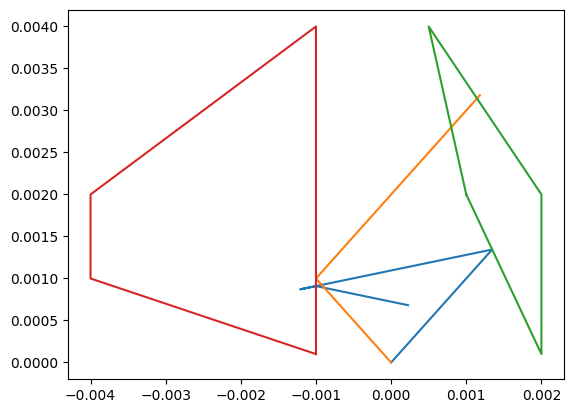

In [22]:
from shapely.geometry import LineString, Polygon, MultiPoint, Point
import numpy as np
import matplotlib.pyplot as plt

# 原点坐标
origin = Point(0, 0)
# 将角度转化为弧度
#angles = [np.deg2rad(angle) for angle in [0, 45, 90, 135, 180, 225, 270, 315]]
angles = [np.deg2rad(angle) for angle in [45, 135]]

# 500米对应的经纬度数值大致是0.0045
#max_distance = 0.0045
# 假设存在一个多边形
polygons = [Polygon([(0.001, 0.002), (0.0005, 0.004), (0.002, 0.002), (0.002, 0.0001)]), 
            Polygon([(-0.001, 0.0001), (-0.001, 0.004), (-0.004, 0.002), (-0.004, 0.001)]),
            ] 


def find_reflected_ray(ray, polygon, max_distance):
    # 找到交点
    intersections = ray.intersection(polygon.exterior)

    #if intersections.is_empty:
    #    return None  # 返回None表示没有反射

    # 求出交点的坐标
    if isinstance(intersections, Point):
        hit_point = intersections.coords[0]
    elif isinstance(intersections, MultiPoint):
        # 计算所有交点到 ray 的起点的距离，找到最近的那一个
        distances = [distance(ray.coords[0], point.coords[0]) for point in intersections.geoms]
        closest_index = distances.index(min(distances))
        hit_point = intersections.geoms[closest_index].coords[0]

    dx_1, dy_1 = np.array([origin.x, origin.y]) - np.array(hit_point)
    length_o_h = np.sqrt(dx_1 ** 2 + dy_1 ** 2)

    remain_distance = max_distance - length_o_h
    # 找到多边形边的单位法线向量
    dx, dy = np.array(polygon.exterior.coords[0]) - np.array(hit_point)
    #normal = np.array([dy / length, -dx / length])
    edge_with_hit = find_edge(polygon, hit_point)
    normal = calculate_normal(edge_with_hit)

    # 计算反射向量
    direction = np.array(ray.coords[-1]) - np.array(hit_point)
    direction /= np.linalg.norm(direction)

    reflection = direction - 2 * np.dot(direction, normal) * normal

    # 计算反射射线
    reflected_ray_end_point = hit_point + remain_distance * reflection
    reflected_ray = LineString([hit_point, tuple(reflected_ray_end_point)])

    return reflected_ray,remain_distance

def find_edge(polygon, hit_point):
    coords = polygon.exterior.coords[:]
    min_distance = float('inf')
    hit_edge = None
    for i in range(len(coords) - 1):
        p1, p2 = coords[i], coords[i + 1]
        line = LineString([p1, p2])
        distance = line.distance(Point(hit_point))
        if distance < min_distance:
            min_distance = distance
            hit_edge = line
    return hit_edge

def calculate_normal(edge):
    dx = edge.coords[-1][0] - edge.coords[0][0]
    dy = edge.coords[-1][1] - edge.coords[0][1]
    length = np.sqrt(dx ** 2 + dy ** 2)
    return np.array([-dy / length, dx / length]) 

def distance(point1, point2):
    # 使用欧几里德距离公式
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5




for angle in angles:
    max_distance = 0.0045
    # 创建射线
    dx, dy = np.cos(angle) * max_distance, np.sin(angle) * max_distance
    ray = LineString([origin, Point(origin.x + dx, origin.y + dy)])

    # 记录每一段射线的终点，用于画图
    end_points = [ray.coords[1]]
    remain_distance = 0
    i = 0
    
    for i in range(len(polygons)):
        intersections = ray.intersection(polygons[i].exterior)
        
        if intersections.is_empty:
            continue # 如果没有发生反射，就跳出循环
        else :
            ray,remain_distance = find_reflected_ray(ray, polygons[i], max_distance)

            #if i == 0:
            ## 记录反射后的射线的终点
            #    end_points.pop(0)
            #    end_points.append(ray.coords[0])
            #    end_points.append(ray.coords[1])
            #else :
            #    end_points.append(ray.coords[0])
            #    end_points.append(ray.coords[1])
            
            end_points.append(ray.coords[0])
            end_points.append(ray.coords[1])
    
        
        max_distance = remain_distance

    # 画出射线
    if len(end_points) > 2:
        end_points.pop(0)
    xs, ys = zip(*[(origin.x, origin.y)] + end_points)
    plt.plot(xs, ys)

# 画出多边形
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y)

plt.show()

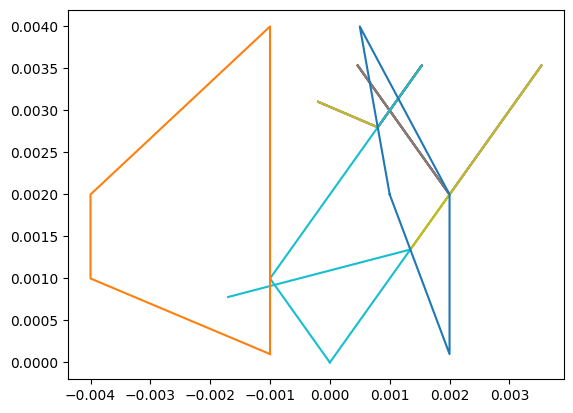

In [15]:
from shapely.geometry import LineString, Polygon, MultiPoint, Point
import numpy as np
import matplotlib.pyplot as plt

# 原点坐标
origin = Point(0, 0)
# 将角度转化为弧度
#angles = [np.deg2rad(angle) for angle in [0, 45, 90, 135, 180, 225, 270, 315]]
angles = [np.deg2rad(angle) for angle in [45, 135]]

# 500米对应的经纬度数值大致是0.0045
#max_distance = 0.0045
# 假设存在一个多边形
polygons = [Polygon([(0.001, 0.002), (0.002, 0.0001), (0.002, 0.002), (0.0005, 0.004)]),
            Polygon([(-0.001, 0.0001), (-0.001, 0.004), (-0.004, 0.002), (-0.004, 0.001)]),
            ] 


def find_reflected_ray(ray, polygon, max_distance):
    # 找到交点
    intersections = ray.intersection(polygon.exterior)

    #if intersections.is_empty:
    #    return None  # 返回None表示没有反射

    # 求出交点的坐标
    if isinstance(intersections, Point):
        hit_point = intersections.coords[0]
    elif isinstance(intersections, MultiPoint):
        # 计算所有交点到 ray 的起点的距离，找到最近的那一个
        distances = [distance(ray.coords[0], point.coords[0]) for point in intersections.geoms]
        closest_index = distances.index(min(distances))
        hit_point = intersections.geoms[closest_index].coords[0]

    x, y = ray.coords[0]
    dx_1, dy_1 = np.array([x,y]) - np.array(hit_point)
    length_o_h = np.sqrt(dx_1 ** 2 + dy_1 ** 2)

    remain_distance = max_distance - length_o_h
    # 找到多边形边的单位法线向量
    #dx, dy = np.array(polygon.exterior.coords[0]) - np.array(hit_point)
    #normal = np.array([dy / length, -dx / length])
    edge_with_hit = find_edge(polygon, hit_point)
    normal = calculate_normal(edge_with_hit)

    # 计算反射向量
    direction = np.array(ray.coords[-1]) - np.array(hit_point)
    direction /= np.linalg.norm(direction)

    reflection = direction - 2 * np.dot(direction, normal) * normal

    # 计算反射射线
    reflected_ray_end_point = hit_point + remain_distance * reflection
    reflected_ray = LineString([hit_point, tuple(reflected_ray_end_point)])

    return reflected_ray,remain_distance

def find_edge(polygon, hit_point):
    coords = polygon.exterior.coords[:]
    min_distance = float('inf')
    hit_edge = None
    for i in range(len(coords) - 1):
        p1, p2 = coords[i], coords[i + 1]
        line = LineString([p1, p2])
        distance = line.distance(Point(hit_point))
        if distance < min_distance:
            min_distance = distance
            hit_edge = line
    return hit_edge

def calculate_normal(edge):
    dx = edge.coords[-1][0] - edge.coords[0][0]
    dy = edge.coords[-1][1] - edge.coords[0][1]
    length = np.sqrt(dx ** 2 + dy ** 2)
    if dx * dy > 0:
        dx, dy = dy, dx
    return np.array([-dy / length, dx / length]) 

def distance(point1, point2):
    # 使用欧几里德距离公式
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5



def find_ray(ray, polygons, max_distance,flag,reflections):
    end_points = [ray.coords[1]]
    remain_distance = max_distance
    # 反射计数
    max_reflections=10
    i = 0
    
    for polygon in polygons:
        intersections = ray.intersection(polygon.exterior)

        if not intersections.is_empty:
            ray, remain_distance = find_reflected_ray(ray, polygon, max_distance)
            reflections += 1  # 当发生反射时，增加反射计数
            if remain_distance <= 0 or reflections >= max_reflections: 
                break
            end_points.append(ray.coords[0])
            end_points.append(ray.coords[1])
            if remain_distance > 0:
                ray, remain_distance = find_ray(ray, polygons, remain_distance,0,reflections) # 递归调用
                if remain_distance <= 0:
                    break
            else:
                return ray, remain_distance
            end_points.pop(0)

    #if len(end_points) > 2:
    #        end_points.pop(0)
    if flag:
        xs, ys = zip(*[(origin.x, origin.y)] + end_points)
        plt.plot(xs, ys)
    else :
        xs, ys = zip(*([ray.coords[0]] + end_points))
        plt.plot(xs, ys)

    return ray, remain_distance

for angle in angles:
        max_distance = 0.005
        # 创建射线
        dx, dy = np.cos(angle) * max_distance, np.sin(angle) * max_distance
        ray = LineString([origin, Point(origin.x + dx, origin.y + dy)])
        find_ray(ray,polygons,max_distance,1,0)
# 画出多边形
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y)

plt.show()

IndexError: list index out of range

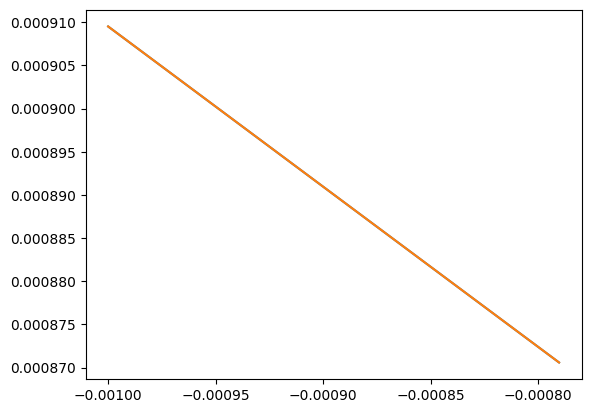

In [58]:
from shapely.geometry import LineString, Polygon, MultiPoint, Point
import numpy as np
import matplotlib.pyplot as plt

# 原点坐标
origin = Point(0, 0)
# 将角度转化为弧度
#angles = [np.deg2rad(angle) for angle in [0, 45, 90, 135, 180, 225, 270, 315]]
angles = [np.deg2rad(angle) for angle in [45, 135]]

# 500米对应的经纬度数值大致是0.0045
#max_distance = 0.0045
# 假设存在一个多边形
polygons = [Polygon([(0.001, 0.002), (0.002, 0.0001), (0.002, 0.002), (0.0005, 0.004)]),
            Polygon([(-0.001, 0.0001), (-0.001, 0.004), (-0.004, 0.002), (-0.004, 0.001)]),
            Polygon([(0.01, 0.02), (0.02, 0.01), (0.02, 0.02), (0.01, 0.04)]),
            ] 


def find_reflected_ray(ray, polygon, max_distance):
    # 找到交点
    intersections = ray.intersection(polygon.exterior)

    #if intersections.is_empty:
    #    return None  # 返回None表示没有反射

    # 求出交点的坐标
    if isinstance(intersections, Point):
        hit_point = intersections.coords[0]
    elif isinstance(intersections, MultiPoint):
        # 计算所有交点到 ray 的起点的距离，找到最近的那一个
        distances = [distance(ray.coords[0], point.coords[0]) for point in intersections.geoms]
        closest_index = distances.index(min(distances))
        hit_point = intersections.geoms[closest_index].coords[0]

    x, y = ray.coords[0]
    dx_1, dy_1 = np.array([x,y]) - np.array(hit_point)
    length_o_h = np.sqrt(dx_1 ** 2 + dy_1 ** 2)

    remain_distance = max_distance - length_o_h
    # 找到多边形边的单位法线向量
    #dx, dy = np.array(polygon.exterior.coords[0]) - np.array(hit_point)
    #normal = np.array([dy / length, -dx / length])
    edge_with_hit = find_edge(polygon, hit_point)
    normal = calculate_normal(edge_with_hit)

    # 计算反射向量
    direction = np.array(ray.coords[-1]) - np.array(hit_point)
    direction /= np.linalg.norm(direction)

    reflection = direction - 2 * np.dot(direction, normal) * normal

    # 计算反射射线
    reflected_ray_end_point = hit_point + remain_distance * reflection
    reflected_ray = LineString([hit_point, tuple(reflected_ray_end_point)])

    return reflected_ray,remain_distance

def find_edge(polygon, hit_point):
    coords = polygon.exterior.coords[:]
    min_distance = float('inf')
    hit_edge = None
    for i in range(len(coords) - 1):
        p1, p2 = coords[i], coords[i + 1]
        line = LineString([p1, p2])
        distance = line.distance(Point(hit_point))
        if distance < min_distance:
            min_distance = distance
            hit_edge = line
    return hit_edge

def calculate_normal(edge):
    dx = edge.coords[-1][0] - edge.coords[0][0]
    dy = edge.coords[-1][1] - edge.coords[0][1]
    length = np.sqrt(dx ** 2 + dy ** 2)
    if dx * dy > 0:
        dx, dy = dy, dx
    return np.array([-dy / length, dx / length]) 

def distance(point1, point2):
    # 使用欧几里德距离公式
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5



#def find_ray(ray, polygons, max_distance):
#    
#    
#        # 记录每一段射线的终点，用于画图
#        end_points = [ray.coords[1]]
#        remain_distance = 0
#        i = 0
#        
#        for i in range(len(polygons)):
#            intersections = ray.intersection(polygons[i].exterior)
#            
#            if intersections.is_empty:
#                continue # 如果没有发生反射，就跳出循环
#            else :
#                ray,remain_distance = find_reflected_ray(ray, polygons[i], max_distance)
#                
#                end_points.append(ray.coords[0])
#                end_points.append(ray.coords[1])
#    
#        # 画出射线
#        if len(end_points) > 2:
#            end_points.pop(0)
#        xs, ys = zip(*[(origin.x, origin.y)] + end_points)
#        plt.plot(xs, ys)
#
#        return ray, remain_distance

def find_ray(ray, removed_polygons,j, max_distance,flag,reflections):
    end_points = [ray.coords[1]]
    remain_distance = max_distance
    # 反射计数
    max_reflections=10
    i = 0
    if i >= len(copied_removed_polygons):
        break
    copied_removed_polygons = removed_polygons.copy()
    for i in range(len(copied_removed_polygons)):
        
        intersections = ray.intersection(copied_removed_polygons[i].exterior)

        if not intersections.is_empty:
            ray, remain_distance = find_reflected_ray(ray, copied_removed_polygons[i], max_distance)
            reflections += 1  # 当发生反射时，增加反射计数
            if remain_distance <= 0 or reflections >= max_reflections: 
                break
            end_points.append(ray.coords[0])
            end_points.append(ray.coords[1])
            
            if remain_distance > 0:
                if flag:
                    copied_removed_polygons = polygons[:i] + polygons[i+1:]
                    ray, remain_distance = find_ray(ray, copied_removed_polygons, i, remain_distance,0,reflections) # 递归调用
                else:
                    if j <= i:
                        copied_removed_polygons = polygons[:i+1] + polygons[i+2:]
                    else:
                        copied_removed_polygons = polygons[:i] + polygons[i+1:]
                    ray, remain_distance = find_ray(ray, copied_removed_polygons, i, remain_distance,0,reflections) # 递归调用
                
            end_points.pop(0)
            

    if flag:
        xs, ys = zip(*[(origin.x, origin.y)] + end_points)
        plt.plot(xs, ys)
    else :
        xs, ys = zip(*([ray.coords[0]] + end_points))
        plt.plot(xs, ys)

    return ray, remain_distance

for angle in angles:
        max_distance = 0.0045
        # 创建射线
        dx, dy = np.cos(angle) * max_distance, np.sin(angle) * max_distance
        ray = LineString([origin, Point(origin.x + dx, origin.y + dy)])
        find_ray(ray,polygons,0, max_distance,1,0)
# 画出多边形
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y)

plt.show()

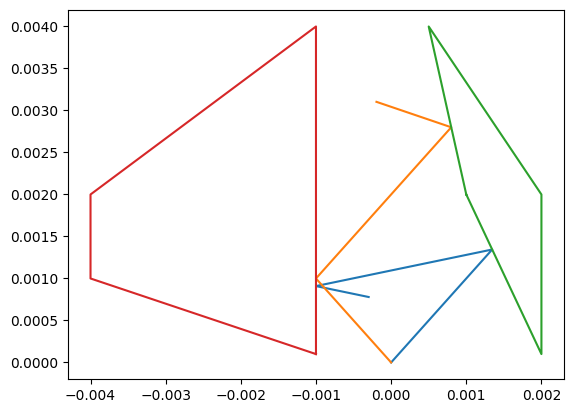

In [1]:
from shapely.geometry import LineString, Polygon, MultiPoint, Point
import numpy as np
import matplotlib.pyplot as plt

# 原点坐标
origin = Point(0, 0)
# 将角度转化为弧度
#angles = [np.deg2rad(angle) for angle in [0, 45, 90, 135, 180, 225, 270, 315]]
angles = [np.deg2rad(angle) for angle in [45, 135]]

# 500米对应的经纬度数值大致是0.0045
#max_distance = 0.0045
# 假设存在一个多边形
polygons = [Polygon([(0.001, 0.002), (0.002, 0.0001), (0.002, 0.002), (0.0005, 0.004)]),
            Polygon([(-0.001, 0.0001), (-0.001, 0.004), (-0.004, 0.002), (-0.004, 0.001)]),
            ] 


def find_reflected_ray(ray, polygon, max_distance):
    # 找到交点
    intersections = ray.intersection(polygon.exterior)

    #if intersections.is_empty:
    #    return None  # 返回None表示没有反射

    # 求出交点的坐标
    if isinstance(intersections, Point):
        hit_point = intersections.coords[0]
    elif isinstance(intersections, MultiPoint):
        # 计算所有交点到 ray 的起点的距离，找到最近的那一个
        distances = [distance(ray.coords[0], point.coords[0]) for point in intersections.geoms]
        closest_index = distances.index(min(distances))
        hit_point = intersections.geoms[closest_index].coords[0]

    x, y = ray.coords[0]
    dx_1, dy_1 = np.array([x,y]) - np.array(hit_point)
    length_o_h = np.sqrt(dx_1 ** 2 + dy_1 ** 2)
    if length_o_h < 0.000001:
        return ray,max_distance

    remain_distance = max_distance - length_o_h
    # 找到多边形边的单位法线向量
    #dx, dy = np.array(polygon.exterior.coords[0]) - np.array(hit_point)
    #normal = np.array([dy / length, -dx / length])
    edge_with_hit = find_edge(polygon, hit_point)
    normal = calculate_normal(edge_with_hit)

    # 计算反射向量
    direction = np.array(ray.coords[-1]) - np.array(hit_point)
    direction /= np.linalg.norm(direction)

    reflection = direction - 2 * np.dot(direction, normal) * normal

    # 计算反射射线
    reflected_ray_end_point = hit_point + remain_distance * reflection
    reflected_ray = LineString([hit_point, tuple(reflected_ray_end_point)])

    return reflected_ray,remain_distance

def find_edge(polygon, hit_point):
    coords = polygon.exterior.coords[:]
    min_distance = float('inf')
    hit_edge = None
    for i in range(len(coords) - 1):
        p1, p2 = coords[i], coords[i + 1]
        line = LineString([p1, p2])
        distance = line.distance(Point(hit_point))
        if distance < min_distance:
            min_distance = distance
            hit_edge = line
    return hit_edge

def calculate_normal(edge):
    dx = edge.coords[-1][0] - edge.coords[0][0]
    dy = edge.coords[-1][1] - edge.coords[0][1]
    length = np.sqrt(dx ** 2 + dy ** 2)
    if dx * dy > 0:
        dx, dy = dy, dx
    return np.array([-dy / length, dx / length]) 

def distance(point1, point2):
    # 使用欧几里德距离公式
    return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5



def find_ray(ray, polygons, max_distance):
    remain_distance = max_distance
    
    
    for polygon in polygons:
        intersections = ray.intersection(polygon.exterior)

        if not intersections.is_empty:
            ray_copy = ray
            ray, remain_distance = find_reflected_ray(ray, polygon, max_distance)
            if ray_copy == ray:
                continue
            if remain_distance <= 0 : 
                break
            return ray, remain_distance
            

    return ray, remain_distance

for angle in angles:
        max_distance = 0.005
        # 创建射线
        dx, dy = np.cos(angle) * max_distance, np.sin(angle) * max_distance
        ray = LineString([origin, Point(origin.x + dx, origin.y + dy)])
        ray_1 = LineString([origin, Point(origin.x + 1, origin.y + 1)])
        end_points = [ray.coords[1]]

        for i in range(10):
            if i == 0:
                if ray_1 != ray:
                    ray_1, remain_distance = find_ray(ray,polygons,max_distance)
                    end_points.pop(0)
                    #xs, ys = zip(*[(origin.x, origin.y), ray_1.coords[0],ray_1.coords[1]])
                    end_points.append(ray_1.coords[0])
                    end_points.append(ray_1.coords[1])
            else:
                if ray_1 != ray:
                    ray = ray_1
                    ray_1, remain_distance = find_ray(ray_1,polygons,remain_distance)
                    if ray_1 != ray:
                        end_points.pop(len(end_points)-1)
                        end_points.append(ray_1.coords[0])
                        end_points.append(ray_1.coords[1])
        xs, ys = zip(*[(origin.x, origin.y)] + end_points)
        plt.plot(xs, ys)
# 画出多边形
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y)

plt.show()

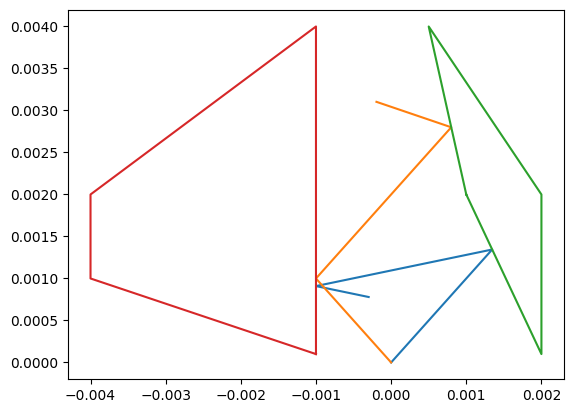

In [30]:
def find_and_graph_ray(angle, polygons, origin):
    max_distance = 0.005
    dx, dy = np.cos(angle) * max_distance, np.sin(angle) * max_distance
    ray = LineString([origin, Point(origin.x + dx, origin.y + dy)])
    ray_1 = LineString([origin, Point(origin.x + 1, origin.y + 1)])
    end_points = [ray.coords[1]]

    for i in range(10):
        if ray_1 != ray:
            ray,(ray_1, remain_distance) = ray_1, find_ray(ray if i==0 else ray_1, polygons, max_distance if i==0 else remain_distance)
            if ray_1 != ray:
                end_points.pop(0) if i==0 else end_points.pop(-1)
                end_points.extend([ray_1.coords[0], ray_1.coords[1]])

    return end_points 

for angle in angles:
    end_points = find_and_graph_ray(angle, polygons, origin)
    xs, ys = zip(*[(origin.x, origin.y)] + end_points)
    plt.plot(xs, ys)
for polygon in polygons:
    x, y = polygon.exterior.xy
    plt.plot(x, y)
plt.show()